# Structured Illumination Microscopy
## Basic reconstruction of SIM
---
**Notebook 5 — 2026**
<div style="font-size:15px; padding:8px; margin:2px; font-weight:600; background-color:#E80808; color:white;text-align:center;">
    <div style=" ">
        Introduction to Multidimensional Fourier Transform
    </div>
</div>
<div style="border-bottom: 1px gray dotted; padding:8px;margin:2px;text-align:center; font-size:15px; color:#444;">
<i>Daniel Sage — École Polytechnique Fédérale de Lausanne (EPFL)</i>
</div>

**Important notice**: These interactive notebooks complement the lecture and are not self-contained; in-class explanations are required.

In [6]:
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from matplotlib.patches import Circle
from skimage.filters import gaussian
plt.rcParams["figure.dpi"]=120

size=256
px=100e-9
fwhm_psf=600e-9
period_illum=fwhm_psf * np.sqrt(2)

sigma=fwhm_psf/(2*np.sqrt(2*np.log(2)))
fc=1/(2*np.pi*sigma)*px
period_px=period_illum/px
k0=1/period_px

def fft2c(x): return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(F): return np.fft.ifft2(np.fft.ifftshift(F))
def radial_grid(n):a=(np.arange(n)-n//2)/n; X,Y=np.meshgrid(a,a); return np.sqrt(X*X+Y*Y)
def snr(x,y): return 10*np.log10(np.mean(x*x)/(np.mean((x-y)**2)+1e-12))
def showim(ax,img,t,vmin=None,vmax=None):
    ax.imshow(img,cmap="gray",vmin=vmin,vmax=vmax); ax.set_title(t,fontsize=11); ax.axis("off")
def showFM(ax,F,t):
    ax.imshow(np.log(np.abs(F)+1e-12),cmap="gray"); ax.set_title(t,fontsize=11); ax.axis("off")


## 6.1 Generate a synthetic structure — Siemens Star

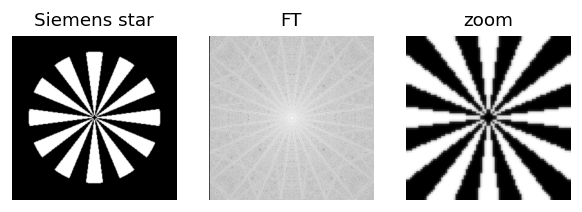

In [7]:
def siemens_star(n=128, spokes=12):
    yy,xx=np.mgrid[-1:1:complex(n),-1:1:complex(n)]
    r=np.sqrt(xx*xx+yy*yy); th=np.arctan2(yy,xx)
    img=(np.cos(spokes*th)>0).astype(float)
    img*= (r<0.8); img=gaussian(img,0.5)
    img=(img-img.min())/(img.max()-img.min())
    return img

img=siemens_star(size)
fig,ax=plt.subplots(1,3,figsize=(6,3))
showim(ax[0],img,"Siemens star")
showFM(ax[1],fft2c(img),"FT")
showim(ax[2],img[size//2-40:size//2+40,size//2-40:size//2+40],"zoom")
plt.show()

## 6.2 PSF as a pupil function

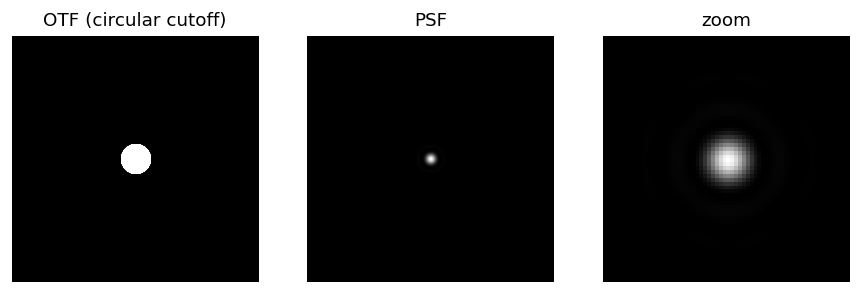

In [8]:
r=radial_grid(size)
H=(r<=fc).astype(float)
psf=np.abs(ifft2c(H))**2
psf=np.fft.fftshift(psf)/psf.sum()

fig,ax=plt.subplots(1,3,figsize=(9,3))
showim(ax[0],H,"OTF (circular cutoff)")
showim(ax[1],psf,"PSF")
showim(ax[2],psf[size//2-32:size//2+32,size//2-32:size//2+32],"zoom")
plt.show()

## 6.3 Simulation of the illumination patterns

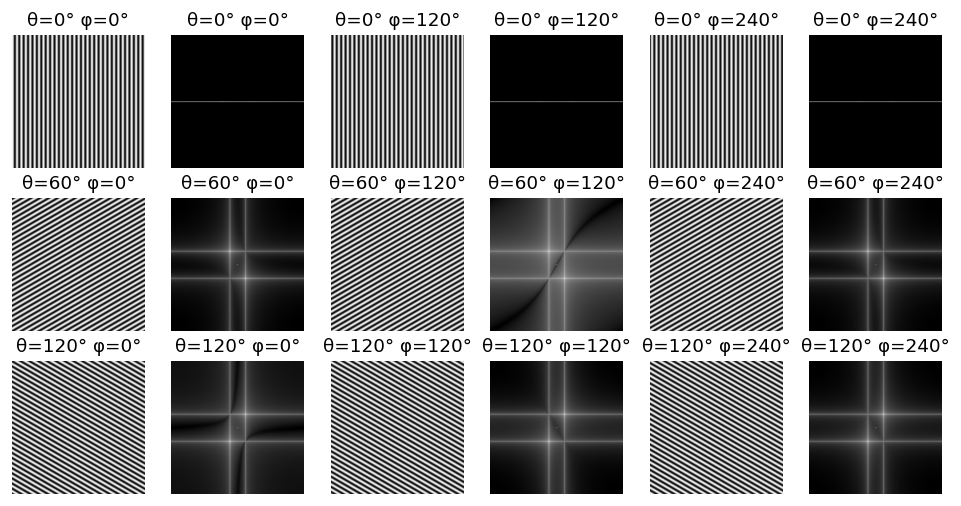

In [9]:
def illum_patterns(n, angles, phases, k0, m=0.9):
    x=(np.arange(n)-n//2)
    X,Y=np.meshgrid(x,x)

    P=[]; meta=[]
    for ia,th in enumerate(angles):
        kx=k0*np.cos(th); ky=k0*np.sin(th)
        for ip,ph in enumerate(phases):
            P.append(1+m*np.cos(2*np.pi*(kx*X+ky*Y)+ph))
    return np.stack(P,0)

angles=np.deg2rad([0,60,120])
phases=np.deg2rad([0,120,240])
    
P=illum_patterns(size,angles,phases,k0,m=1)
fig,ax=plt.subplots(3,6,figsize=(10,5))
for i in range(3):
    for j in range(3): 
        angle = round(np.rad2deg(angles[j])); phase = round(np.rad2deg(phases[i]))
        showim(ax[j,2*i],P[i+3*j],f"θ={angle}° φ={phase}°")
        showFM(ax[j,2*i+1], fft2c(P[i+3*j]),f"θ={angle}° φ={phase}°")
        #showFM(ax[ia*2,ip],P[i]F=fft2c(P[i]-P[i].mean()),f"θ={adeg}° φ={pdeg}°")
plt.show()

## 6.4 Simulation of widefield acquisition

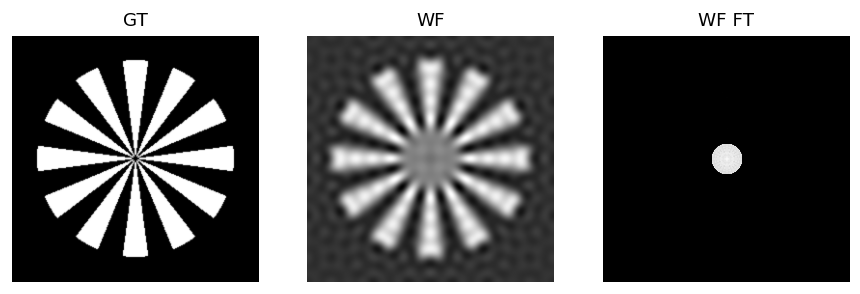

In [10]:
wf=np.real(ifft2c(fft2c(img) * H))

fig,ax=plt.subplots(1,3,figsize=(9,12))
showim(ax[0],img,"GT")
showim(ax[1],wf,"WF")
showFM(ax[2],fft2c(wf),"WF FT")

## 6.5 Simulation of SIM acquisition

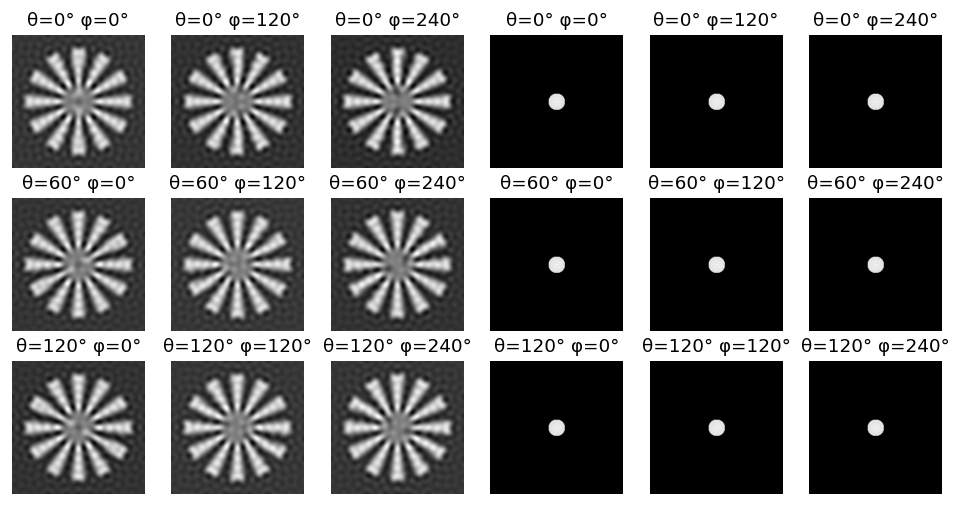

In [11]:
def conv(x): return np.real(ifft2c(fft2c(x)*H))

y=np.stack([conv(img*P[i]) for i in range(9)])
wf=conv(img)

P=illum_patterns(size,angles,phases,k0,m=1)
fig,ax=plt.subplots(3,6,figsize=(10,5))
for i in range(3):
    for j in range(3): 
        angle = round(np.rad2deg(angles[j])); phase = round(np.rad2deg(phases[i]))
        showim(ax[j,i],y[i+3*j],f"θ={angle}° φ={phase}°")
        showFM(ax[j,3+i], fft2c(y[i+3*j]),f"θ={angle}° φ={phase}°")
plt.show()

## 6.6 Partial SIM reconstruction

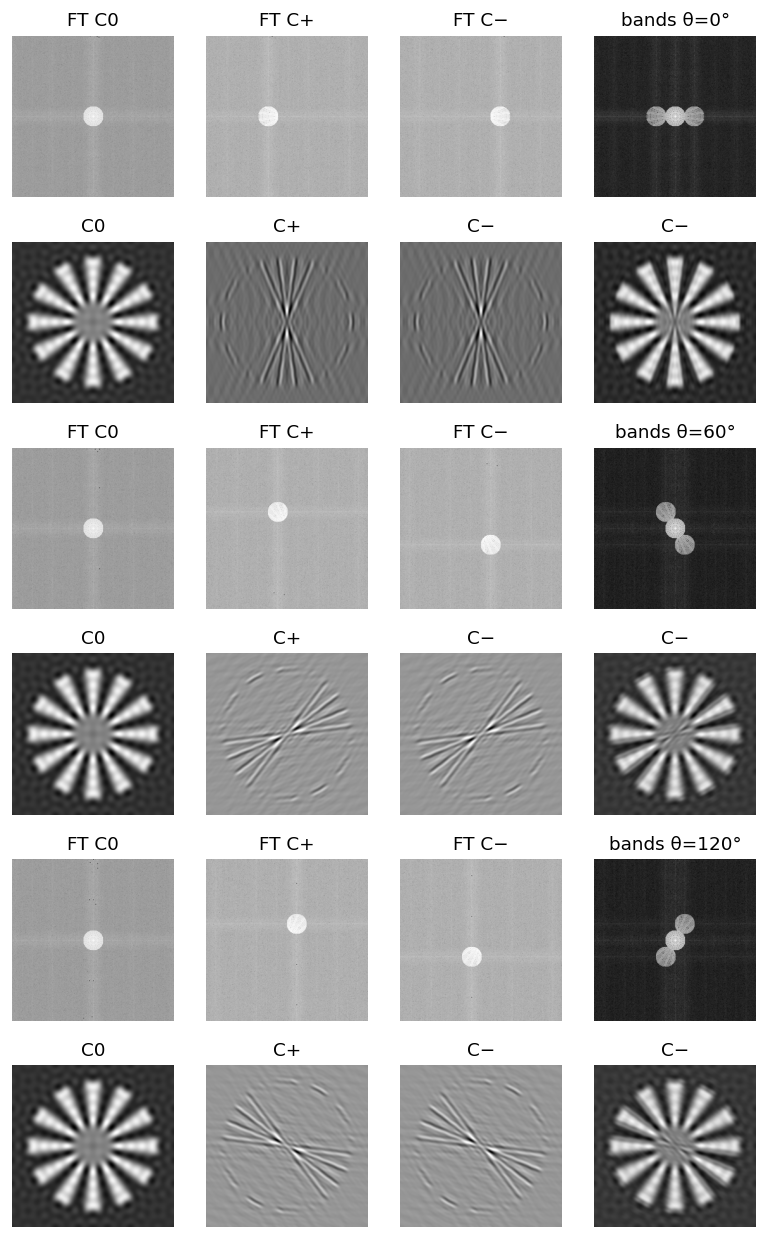

In [12]:
A = np.array([[1, np.exp(1j*p), np.exp(-1j*p)] for p in phases], dtype=complex)
Ai = np.linalg.inv(A)
u = np.stack([np.cos(angles), np.sin(angles)], axis=1) * k0

def shiftF(F, dy, dx): return np.roll(np.roll(F, dy, axis=0), dx, axis=1)

fig, ax = plt.subplots(6, 4, figsize=(8, 13))

for a in range(3):
    Ys = np.stack([fft2c(y[3*a+j])/(H+1e-12) for j in range(3)], axis=0)
    C0 = Ai[0,0]*Ys[0] + Ai[0,1]*Ys[1] + Ai[0,2]*Ys[2]
    Cp = Ai[1,0]*Ys[0] + Ai[1,1]*Ys[1] + Ai[1,2]*Ys[2]
    Cm = Ai[2,0]*Ys[0] + Ai[2,1]*Ys[1] + Ai[2,2]*Ys[2]
    dy = int(np.round(-u[a,1]*size)); dx = int(np.round(-u[a,0]*size))
    Cp = shiftF(Cp, dy, dx); Cm = shiftF(Cm, -dy, -dx)

    showFM(ax[2*a,0], C0, "FT C0")
    showFM(ax[2*a,1], Cp, "FT C+")
    showFM(ax[2*a,2], Cm, "FT C−")
    showFM(ax[2*a,3], np.abs(C0) + np.abs(Cp) + np.abs(Cm), f"bands θ={round(np.rad2deg(angles[a]))}°")
    showim(ax[2*a+1,0], np.real(ifft2c(C0)), "C0")
    showim(ax[2*a+1,1], np.real(ifft2c(Cp)), "C+")
    showim(ax[2*a+1,2], np.real(ifft2c(Cm)), "C−")
    showim(ax[2*a+1,3], np.real(ifft2c((C0) + (Cp) + (Cm))), "C−")
plt.show()

## 6.7 SIM reconstruction

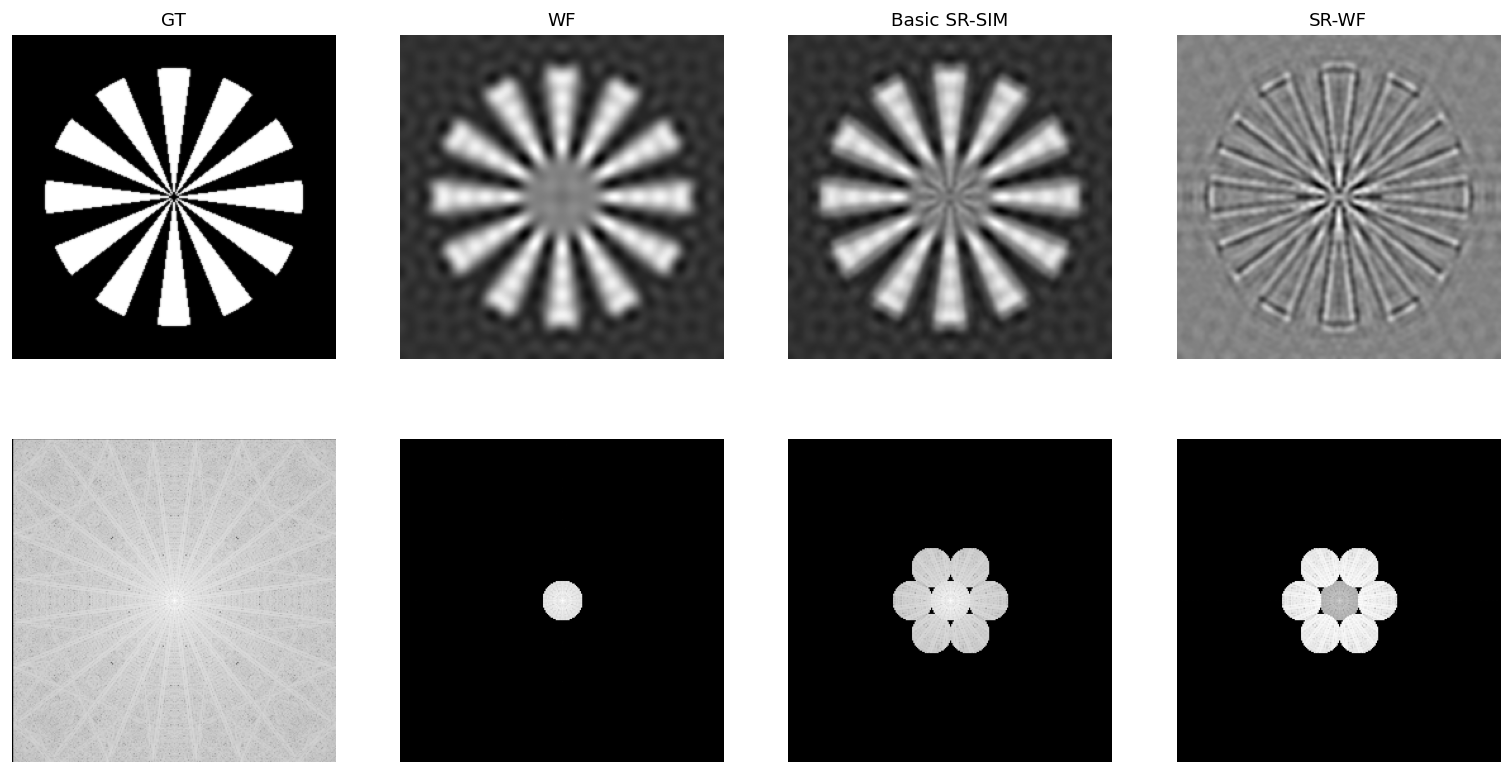

In [13]:
def wmerge(Fs,Hs,w=1e-2):
    num=0; den=0
    for F,Hh in zip(Fs,Hs):
        num+=np.conj(Hh)*F; den+=np.abs(Hh)**2
    return num/(den+w*w)

H0=[H,H,H]
Hp=[]; Hm=[]
for a in range(3):
    dy=int(np.round(-u[a,1]*size)); dx=int(np.round(-u[a,0]*size))
    Hp.append(shiftF(H,dy,dx)); Hm.append(shiftF(H,-dy,-dx))

comps=[]
for a in range(3):
    Ys=np.stack([fft2c(y[3*a+j])/(H+1e-12) for j in range(3)],0)
    C0=Ai[0,0]*Ys[0]+Ai[0,1]*Ys[1]+Ai[0,2]*Ys[2]
    Cp=Ai[1,0]*Ys[0]+Ai[1,1]*Ys[1]+Ai[1,2]*Ys[2]
    Cm=Ai[2,0]*Ys[0]+Ai[2,1]*Ys[1]+Ai[2,2]*Ys[2]
    dy=int(np.round(-u[a,1]*size)); dx=int(np.round(-u[a,0]*size))
    Cp=shiftF(Cp,dy,dx); Cm=shiftF(Cm,-dy,-dx)
    comps.append((C0,Cp,Cm))
F0=wmerge([comps[a][0] for a in range(3)],H0,1e-2)
Fp=wmerge([comps[a][1] for a in range(3)],Hp,1e-2)
Fm=wmerge([comps[a][2] for a in range(3)],Hm,1e-2)

Fsim=F0+0.5*(Fp+Fm)
rec=np.real(ifft2c(Fsim))
#rec=np.clip(rec,0,1)

fig,ax=plt.subplots(2,4,figsize=(16,8))
showim(ax[0,0],img,"GT")
showim(ax[0,1],wf,"WF")
showim(ax[0,2],rec,"Basic SR-SIM")
showim(ax[0,3],rec-wf,"SR-WF")
showFM(ax[1,0],fft2c(img),"")
showFM(ax[1,1],fft2c(wf),"");
showFM(ax[1,2],Fsim,"")
showFM(ax[1,3],fft2c(rec-wf),"")
plt.show()

## 6.8 Demonstrator SIM

In [14]:
def conv(x): return np.real(ifft2c(fft2c(x)*H))
def shiftF(F,dy,dx): return np.roll(np.roll(F,dy,0),dx,1)
def merge_wiener(Fs,Hs,reg_wiener):
    num=0; den=0
    for F,Hh in zip(Fs,Hs):
        num+=np.conj(Hh)*F
        den+=np.abs(Hh)**2
    return num/(den+reg_wiener*reg_wiener)
   
@interact(fc=FloatSlider(min=0.01,max=0.25,step=0.002,value=float(fc)),
          k0=FloatSlider(min=0.05,max=0.22,step=0.002,value=float(k0)),
          reg_wiener=FloatSlider(min=0.01,max=1,step=0.01,value=1e-2,readout_format='.4f'))
def demo(fc,k0,reg_wiener):
    angles=np.deg2rad([0,60,120])
    phases=np.deg2rad([0,120,240])

    r=radial_grid(size)
    H=(r<=fc).astype(float)
    psf=np.abs(ifft2c(H))**2; psf/=psf.sum()
    P=illum_patterns(size,angles,phases,k0,m=0.9)
    y=np.stack([conv(img*P[i]) for i in range(9)])
    wf=conv(img)
    A=np.array([[1,np.exp(1j*p),np.exp(-1j*p)] for p in phases],dtype=complex)
    Ai=np.linalg.inv(A)
    u=np.stack([np.cos(angles),np.sin(angles)],1)*k0
        
    comps=[]
    for a in range(3):
        Ys=np.stack([fft2c(y[3*a+j])/(H+1e-12) for j in range(3)],0)
        C0=Ai[0,0]*Ys[0]+Ai[0,1]*Ys[1]+Ai[0,2]*Ys[2]
        Cp=Ai[1,0]*Ys[0]+Ai[1,1]*Ys[1]+Ai[1,2]*Ys[2]
        Cm=Ai[2,0]*Ys[0]+Ai[2,1]*Ys[1]+Ai[2,2]*Ys[2]
        dy=int(np.round(-u[a,1]*size)); dx=int(np.round(-u[a,0]*size))
        Cp=shiftF(Cp,dy,dx); Cm=shiftF(Cm,-dy,-dx)
        comps.append((C0,Cp,Cm))
        
    H0=[H,H,H]
    Hp=[]; Hm=[]
    for a in range(3):
        dy=int(np.round(-u[a,1]*size)); dx=int(np.round(-u[a,0]*size))
        Hp.append(shiftF(H,dy,dx)); Hm.append(shiftF(H,-dy,-dx))
    F0=merge_wiener([comps[a][0] for a in range(3)],H0,reg_wiener)
    Fp=merge_wiener([comps[a][1] for a in range(3)],Hp,reg_wiener)
    Fm=merge_wiener([comps[a][2] for a in range(3)],Hm,reg_wiener)
    Fsim=F0+0.5*(Fp+Fm)
    rec=np.real(ifft2c(Fsim))
  
    fig,ax=plt.subplots(2,4,figsize=(12,6))
    showim(ax[0,0],img,f"WF  SNR={snr(img,img):.2f} dB")
    showim(ax[0,1],wf,f"WF  SNR={snr(img,wf):.2f} dB")
    showim(ax[0,2],rec,f"WF  SNR={snr(img,rec):.2f} dB")
    showim(ax[0,3],np.clip(rec-wf,0,1),"SR-WF")
    showFM(ax[1,0],fft2c(P[0]-P[0].mean()),"FT illum (θ0 φ0)")
    showFM(ax[1,1],fft2c(wf),"WF FT")
    showFM(ax[1,2],Fsim,"SR FT")
    showFM(ax[1,3],fft2c(wf),"PSF")
    plt.show()

interactive(children=(FloatSlider(value=0.0624635417097592, description='fc', max=0.25, min=0.01, step=0.002),…